# Report Plots

## Importing Packages and Downloading Tools

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns
import random
import time

In [2]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/utils.py')

def read_graph(filename):
    """Reads a graph from a .txt file"""
    G = nx.Graph()
    array = np.loadtxt(filename, dtype=int)
    G.add_edges_from(array)
    return G

## Downloading Facebook Data

In [3]:
download('https://snap.stanford.edu/data/facebook_combined.txt.gz')
fb = read_graph('facebook_combined.txt.gz')
print(len(fb.nodes()))
print(len(fb.edges()))

4039
88234


## Downloading Electrical Grid Graph

This graph is a model of the Western United States electrical grid. You can find more information [here](http://konect.cc/networks/opsahl-powergrid/).

In [4]:
eg = read_graph('opsahl-powergrid/out.opsahl-powergrid')
print(len(eg.nodes()))
print(len(eg.edges()))

4941
6594


In [5]:
n = 4941
m = 6594
k = int(2*m/n)
print(k)

2


## Helper Functions


In [6]:



def sample_path_lengths(G, nodes=None, trials=1000):
    """Choose random pairs of nodes and compute the path length between them.

    G: Graph
    nodes: list of nodes to choose from
    trials: number of pairs to choose

    returns: list of path lengths
    """
    if nodes is None:
        nodes = list(G)
    else:
        nodes = list(nodes)
    
    pairs = np.random.choice(nodes, (trials, 2))
    lengths = []
    for pair in pairs:
        try:
            path = nx.shortest_path_length(G, *pair)
            lengths.append(path)
        except:
            pass
    return lengths


def average_shortest_path(G):
    """Returns the average shortest path length between two random nodes over n trials
    """
    return np.mean(sample_path_lengths(G))


def clusters(G):
    """Finds the largest connected cluster in the graph, G, and the average size of all isolated clusters
    returns a tuple of (relative largest cluster size, average isolated cluster size)
    """
    largest = len(max(nx.connected_components(G), key=len))
    sizes = [len(i) for i in nx.connected_components(G)]
    sizes.remove(largest)
    average_isolated = np.mean(sizes) if sizes else 0
    return largest/len(G.nodes()), average_isolated


def run_attack(G, attack, step=.01, max_removal=0.8):
    """ Runs as attack (either targeted or random) on a graph then returns properties that are useful
    for analysis.
    
    G: Graph to attack
    attack: type of attack function to test
    step: what fraction (of nodes/edges) to remove on every step
    max_removal: the maximum fraction to stop at
    
    Returns a tuple of lists:
    (fraction steps, relative largest size, average isolated size, average shortest path)
    """
    G = G.copy()
    k = int(max_removal/step)
    f_step = np.linspace(0,k,k+1)*step
    rel_largest, avg_isolated, avg_path = [], [], []
    n = len(G)
    m = len(G.edges())

    t0 = time.time()
    for i in f_step:
        # calculate cluster properties
        rel_lg, avg_iso = clusters(G)

        # add properties
        rel_largest.append(rel_lg)
        avg_isolated.append(avg_iso)
#         if (rel_lg >= 1.0):
        avg_path.append(average_shortest_path(G))
        
        # remove nodes
        attack(G, int(step*n), int(step*m))
            
    print("time: ", time.time() - t0)
    return (f_step, rel_largest, avg_isolated, avg_path)

## Random Node Removal

In [7]:
def random_node_attack(G, k, m):
    """Returns a graph with k nodes removed at random"""
    nodes_removed = random.sample(list(G.nodes),k=k)
    G.remove_nodes_from(nodes_removed)

## Targeted Node Removal

In [8]:
def target_node_attack(G, k, m):
    """
    Targets k nodes with the most connections, then removes those node.
    G: Graph to target
    """
    for i in range(k):
        degrees = dict(G.degree())
        target = max(degrees, key=degrees.get)
        G.remove_node(target)

## Random Edge Removal

In [9]:
def random_edge_attack(G, k, m):
    """Returns a graph with k nodes removed at random"""
    edges_removed = random.sample(list(G.edges),k=m)
    G.remove_edges_from(edges_removed)

## Pickling

In [10]:
# Store data
import pickle
import os


def store(file, data):
    files = os.listdir("data/")
    count = len([i for i in files if i[:len(file)] == file])
    filename = 'data/' + file + '_' + str(count) + '.pickle'
    with open(filename, 'wb') as handle:
        pickle.dump(data, handle)

def load(file):
    filename = 'data/' + file + '.pickle'
    with open(filename, 'rb') as handle:
        data = pickle.load(handle)
    return data

def load_avg(file):
    files = os.listdir("data/")
    count = len([i for i in files if i[:len(file)] == file])
    data = [load(file + '_' + str(i)) for i in range(count)]
    
    f_step = data[0][0]
    rel_largest = []
    avg_isolated = []
    avg_path = []
    
    for i in range(len(f_step)):
        rl = 0
        ai = 0
        ap = 0
        for j in range(count):
            rl += data[j][1][i]
            ai += data[j][2][i]
            ap += data[j][3][i]
        rel_largest.append(rl/count)
        avg_isolated.append(ai/count)
        avg_path.append(ap/count)
        
    return (f_step, rel_largest, avg_isolated, avg_path)
    
    

## Generating Data
To conserve processing time all of the data sets used for the figures are generated once below. There are several data sets we create with the following characteristics:

| name | type | attack | # of nodes | # of edges | step size | max % removed |
|-|-|-|-|-|-|-|
| er_paper_rn | ER | random node | 10,000 | 20,000 | .005 | 80% |
| er_paper_tn | ER | targeted node | 10,000 | 20,000 | .005 | 80% |
| er_paper_re | ER | random edge | 10,000 | 20,000 | .005 | 80% |
| ws_paper_rn | WS | random node | 10,000 | 20,000 | .005 | 80% |
| ws_paper_tn | WS | targeted node | 10,000 | 20,000 | .005 | 80% |
| ws_paper_re | WS | random edge | 10,000 | 20,000 | .005 | 80% |
| fb_rn | real-world | random node | 4,039 | 88,234 | .005 | 20% |
| fb_tn | real-world | targeted node | 4,039 | 88,234 | .005 | 20% |
| fb_re | real-world | random edge | 4,039 | 88,234 | .005 | 20% |
| er_fb_rn | ER | random node | 4,039 | 88,234 | .005 | 80% |
| er_fb_tn | ER | targeted node | 4,039 | 88,234 | .005 | 80% |
| er_fb_re | ER | random edge | 4,039 | 88,234 | .005 | 80% |
| ws_fb_rn | WS | random node | 4,039 | 88,858 | .005 | 80% |
| ws_fb_tn | WS | targeted node | 4,039 | 88,858 | .005 | 80% |
| ws_fb_tn | WS | random edge | 4,039 | 88,858 | .005 | 80% |
| eg_rn | real-world | random node | 4,941 | 6,594 | .005 | 20% |
| eg_tn | real-world | targeted node | 4,941 | 6,594 | .005 | 20% |
| eg_re | real-world | random edge | 4,941 | 6,594 | .005 | 20% |
| er_eg_rn | ER | random node | 4,941 | 6,594 | .005 | 80% |
| er_eg_tn | ER | targeted node | 4,941 | 6,594 | .005 | 80% |
| er_eg_re | ER | random edge | 4,941 | 6,594 | .005 | 80% |
| ws_eg_rn | WS | random node | 4,941 | 8,078 | .005 | 80% |
| ws_eg_tn | WS | targeted node | 4,941 | 8,078 | .005 | 80% |
| ws_eg_tn | WS | random edge | 4,941 | 8,078 | .005 | 80% |


### Paper Data

In [11]:
n = 10000
m = 2*n
k = int(2*m/n)
p_WS = 0.05

ER = nx.gnm_random_graph(n, m)
WS = nx.watts_strogatz_graph(n, k, p_WS)

er_paper_rn = run_attack(ER, random_node_attack, step=.005)
er_paper_tn = run_attack(ER, target_node_attack, step=.005)
er_paper_re = run_attack(ER, random_edge_attack, step=.005)
ws_paper_rn = run_attack(WS, random_node_attack, step=.005)
ws_paper_tn = run_attack(WS, target_node_attack, step=.005)
ws_paper_re = run_attack(WS, random_edge_attack, step=.005)

c:\python37\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\python37\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


time:  24.26300358772278
time:  49.9717276096344
time:  36.2328462600708
time:  49.26905560493469
time:  73.13237118721008
time:  69.51882243156433


### Facebook Data

In [12]:
n = len(fb.nodes())
m = len(fb.edges())
k = int(2*m/n)
p_WS = 0.05

ER = nx.gnm_random_graph(n, m)
WS = nx.watts_strogatz_graph(n, k, p_WS)

er_fb_rn = run_attack(ER, random_node_attack, step=.005)
er_fb_tn = run_attack(ER, target_node_attack, step=.005)
er_fb_re = run_attack(ER, random_edge_attack, step=.005)
ws_fb_rn = run_attack(WS, random_node_attack, step=.005)
ws_fb_tn = run_attack(WS, target_node_attack, step=.005)
ws_fb_re = run_attack(WS, random_edge_attack, step=.005)

fb_rn = run_attack(fb, random_node_attack, step=.005)
# fb_tn = run_attack(fb, target_node_attack, step=.005)
fb_re = run_attack(fb, random_edge_attack, step=.005)

time:  11.436993837356567
time:  16.032328128814697
time:  17.805039405822754
time:  27.543203353881836
time:  34.479342222213745
time:  38.750388383865356
time:  83.02093863487244
time:  114.91295647621155


### Electrical Grid Data

In [13]:
n = len(eg.nodes())
m = len(eg.edges())
k = int(2*m/n)
p_WS = 0.05

ER = nx.gnm_random_graph(n, m)
WS = nx.watts_strogatz_graph(n, k, p_WS)

er_eg_rn = run_attack(ER, random_node_attack, step=.005)
er_eg_tn = run_attack(ER, target_node_attack, step=.005)
er_eg_re = run_attack(ER, random_edge_attack, step=.005)
ws_eg_rn = run_attack(WS, random_node_attack, step=.005)
ws_eg_tn = run_attack(WS, target_node_attack, step=.005)
ws_eg_re = run_attack(WS, random_edge_attack, step=.005)

eg_rn = run_attack(eg, random_node_attack, step=.005)
# eg_tn = run_attack(eg, target_node_attack, step=.005)
eg_re = run_attack(eg, random_edge_attack, step=.005)

time:  13.029999017715454
time:  14.269962072372437
time:  19.17199945449829
time:  12.885998964309692
time:  18.069246530532837
time:  13.985000848770142
time:  77.69485569000244
time:  68.51441407203674


### Adding Current Data to Repo

In [15]:
store("er_paper_rn", er_paper_rn)
store("er_paper_tn", er_paper_tn)
store("er_paper_re", er_paper_re)
store("ws_paper_rn", ws_paper_rn)
store("ws_paper_tn", ws_paper_tn)
store("ws_paper_re", ws_paper_re)

store("er_fb_rn", er_fb_rn)
store("er_fb_tn", er_fb_tn)
store("er_fb_re", er_fb_re)
store("ws_fb_rn", ws_fb_rn)
store("ws_fb_tn", ws_fb_tn)
store("ws_fb_re", ws_fb_re)

store("er_eg_rn", er_eg_rn)
store("er_eg_tn", er_eg_tn)
store("er_eg_re", er_eg_re)
store("ws_eg_rn", ws_eg_rn)
store("ws_eg_tn", ws_eg_tn)
store("ws_eg_re", ws_eg_re)

store("fb_rn", fb_rn)
# store("fb_tn", fb_tn)
store("fb_re", fb_re)

store("eg_rn", eg_rn)
# store("eg_tn", eg_tn)
store("eg_re", eg_re)

### Loading Average Data from Repo

In [16]:
er_paper_tn_avg  = load_avg("er_paper_tn")

er_paper_rn_avg = load_avg("er_paper_rn")
er_paper_tn_avg = load_avg("er_paper_tn")
er_paper_re_avg = load_avg("er_paper_re")
ws_paper_rn_avg = load_avg("ws_paper_rn")
ws_paper_tn_avg = load_avg("ws_paper_tn")
ws_paper_re_avg = load_avg("ws_paper_re")

er_fb_rn_avg = load_avg("er_fb_rn")
er_fb_tn_avg = load_avg("er_fb_tn")
er_fb_re_avg = load_avg("er_fb_re")
ws_fb_rn_avg = load_avg("ws_fb_rn")
ws_fb_tn_avg = load_avg("ws_fb_tn")
ws_fb_re_avg = load_avg("ws_fb_re")

er_eg_rn_avg = load_avg("er_eg_rn")
er_eg_tn_avg = load_avg("er_eg_tn")
er_eg_re_avg = load_avg("er_eg_re")
ws_eg_rn_avg = load_avg("ws_eg_rn")
ws_eg_tn_avg = load_avg("ws_eg_tn")
ws_eg_re_avg = load_avg("ws_eg_re")

fb_rn_avg = load_avg("fb_rn")
fb_tn_avg = load_avg("fb_tn")
fb_re_avg = load_avg("fb_re")

eg_rn_avg = load_avg("eg_rn")
eg_tn_avg = load_avg("eg_tn")
eg_re_avg = load_avg("eg_re")

## Figure 2
The goal of figure 2 is to compare how path lengths change in ER and WS graphs with small failure rates

In [17]:
er_rn = er_paper_rn_avg
er_tn = er_paper_tn_avg
ws_rn = ws_paper_rn_avg
ws_tn = ws_paper_tn_avg

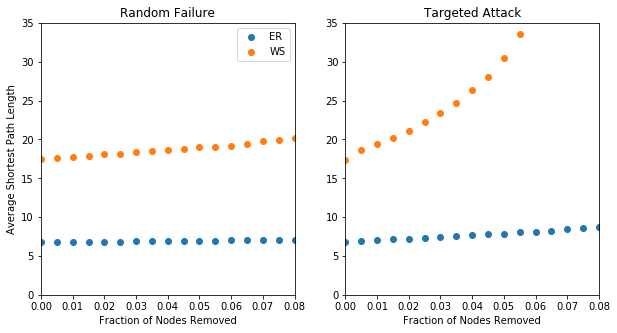

In [18]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(er_rn[0], er_rn[3])
plt.scatter(ws_rn[0], ws_rn[3])
plt.title("Random Failure")
plt.ylabel("Average Shortest Path Length")
plt.xlabel("Fraction of Nodes Removed")
plt.legend(["ER", "WS"])
plt.xlim(0,.08)
plt.ylim(0, 35)

plt.subplot(1,2,2)
plt.scatter(er_tn[0], er_tn[3])
plt.scatter(ws_tn[0], ws_tn[3])
plt.title("Targeted Attack")
plt.xlabel("Fraction of Nodes Removed")
plt.xlim(0,.08)
plt.ylim(0,35)
plt.savefig("C:/Users/wfairman/Desktop/ThinkComplexity2/complex_graph_robustness/reports/figures/fig2.jpg")
plt.show()

## Figure 3

The goal of figure 3 is to evaluate how path lengths change in real-world datasets: Facebook and Electrical Grid

In [21]:
fb_rn = fb_rn_avg
fb_tn = fb_tn_avg

ws_rn = ws_fb_rn_avg
ws_tn = ws_fb_tn_avg

ws_eg_rn = ws_eg_rn_avg
ws_eg_tn = ws_eg_tn_avg
er_eg_rn = er_eg_rn_avg
er_eg_tn = er_eg_tn_avg

eg_rn = eg_rn_avg
eg_tn = eg_tn_avg

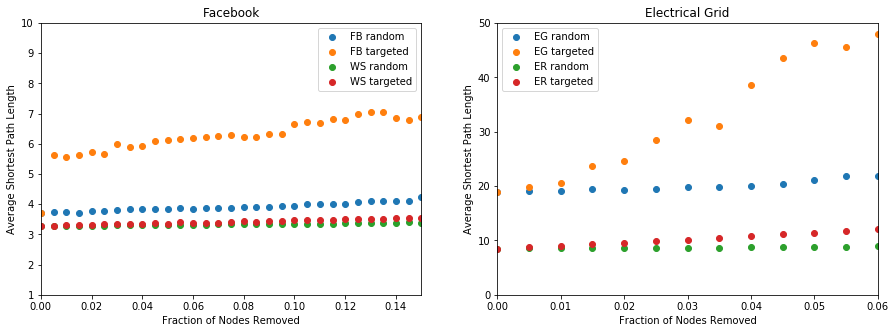

In [22]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(fb_rn[0], fb_rn[3])
plt.scatter(fb_tn[0], fb_tn[3])
plt.scatter(ws_rn[0], ws_rn[3])
plt.scatter(ws_tn[0], ws_tn[3])
plt.legend(["FB random",  "FB targeted", "WS random", "WS targeted"])
plt.xlim(0, .15)
plt.ylim(1, 10)
plt.title("Facebook")
plt.ylabel("Average Shortest Path Length")
plt.xlabel("Fraction of Nodes Removed")

plt.subplot(1,2,2)
plt.scatter(eg_rn[0], eg_rn[3])
plt.scatter(eg_tn[0], eg_tn[3])
plt.scatter(er_eg_rn[0], er_eg_rn[3])
plt.scatter(er_eg_tn[0], er_eg_tn[3])
plt.legend(["EG random", "EG targeted","ER random", "ER targeted"])
plt.xlim(0, .06)
plt.ylim(0, 50)
plt.title("Electrical Grid")
plt.ylabel("Average Shortest Path Length")
plt.xlabel("Fraction of Nodes Removed")


plt.savefig("C:/Users/wfairman/Desktop/ThinkComplexity2/complex_graph_robustness/reports/figures/fig3.jpg")
plt.show()

## Figure 5
The goal of figure 5 is compare S and `<s>` to the data provided by the paper.

In [23]:
er_rn = er_paper_rn_avg
er_tn = er_paper_tn_avg
ws_rn = ws_paper_rn_avg
ws_tn = ws_paper_tn_avg

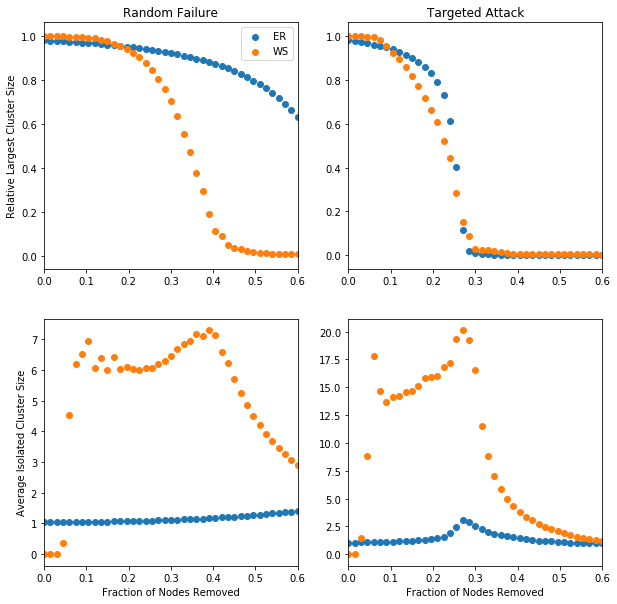

In [24]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.scatter(er_rn[0][::3], er_rn[1][::3])
plt.scatter(ws_rn[0][::3], ws_rn[1][::3])
plt.xlim(0, .6)
plt.title("Random Failure")
plt.ylabel("Relative Largest Cluster Size")
plt.legend(["ER", "WS"])
plt.subplot(2,2,2)
plt.scatter(er_tn[0][::3], er_tn[1][::3])
plt.scatter(ws_tn[0][::3], ws_tn[1][::3])
plt.xlim(0, .6)
plt.title("Targeted Attack")

plt.subplot(2,2,3)
plt.scatter(er_rn[0][::3], er_rn[2][::3])
plt.scatter(ws_rn[0][::3], ws_rn[2][::3])
plt.xlim(0, .6)
plt.ylabel("Average Isolated Cluster Size")
plt.xlabel("Fraction of Nodes Removed")

plt.subplot(2,2,4)
plt.scatter(er_tn[0][::3], er_tn[2][::3])
plt.scatter(ws_tn[0][::3], ws_tn[2][::3])
plt.xlim(0, .6)
plt.xlabel("Fraction of Nodes Removed")

plt.savefig("C:/Users/wfairman/Desktop/ThinkComplexity2/complex_graph_robustness/reports/figures/fig5.jpg")
plt.show()

## Figure  6
The goal of figure 6 is to compare the characteristics found in figure 5 with real-world data

In [41]:
fb_rn = fb_rn_avg
fb_tn = fb_tn_avg

ws_rn = ws_fb_rn_avg
ws_tn = ws_fb_tn_avg

eg_rn = eg_rn_avg
eg_tn = eg_tn_avg

er_rn = er_eg_rn_avg
er_tn = er_eg_tn_avg

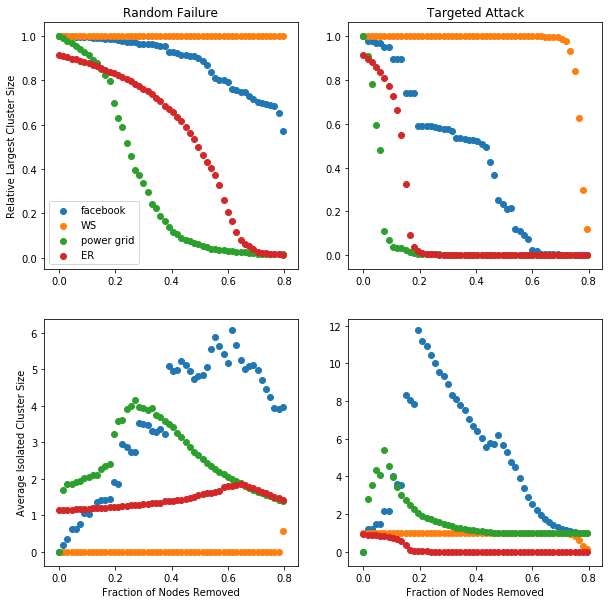

In [49]:
k = 3

plt.figure(figsize=(10,10))
# plt.suptitle("Facebook")
plt.subplot(2,2,1)
plt.scatter(fb_rn[0][::k], fb_rn[1][::k])
plt.scatter(ws_rn[0][::k], ws_rn[1][::k])
plt.scatter(eg_rn[0][::k], eg_rn[1][::k])
plt.scatter(er_rn[0][::k], er_rn[1][::k])
plt.title("Random Failure")
plt.ylabel("Relative Largest Cluster Size")
plt.legend(["facebook", "WS", "power grid", "ER"])
plt.subplot(2,2,2)
plt.scatter(fb_tn[0][::k], fb_tn[1][::k])
plt.scatter(ws_tn[0][::k], ws_tn[1][::k])
plt.scatter(eg_tn[0][::k], eg_tn[1][::k])
plt.scatter(er_tn[0][::k], er_tn[1][::k])
plt.title("Targeted Attack")
plt.subplot(2,2,3)
plt.scatter(fb_rn[0][::k], fb_rn[2][::k])
plt.scatter(ws_rn[0][::k], ws_rn[2][::k])
plt.scatter(eg_rn[0][::k], eg_rn[2][::k])
plt.scatter(er_rn[0][::k], er_rn[2][::k])
plt.ylabel("Average Isolated Cluster Size")
plt.xlabel("Fraction of Nodes Removed")
plt.subplot(2,2,4)
plt.scatter(fb_tn[0][::k], fb_tn[2][::k])
plt.scatter(ws_tn[0][::k], ws_tn[1][::k])
plt.scatter(eg_tn[0][::k], eg_tn[2][::k])
plt.scatter(er_tn[0][::k], er_tn[1][::k])
plt.xlabel("Fraction of Nodes Removed")
plt.savefig("C:/Users/wfairman/Desktop/ThinkComplexity2/complex_graph_robustness/reports/figures/fig6.jpg")
plt.show()

## Figure 6.1
Same as above but with the electrical grid data

In [31]:
eg_rn = eg_rn_avg
eg_tn = eg_tn_avg

er_rn = er_eg_rn_avg
er_tn = er_eg_tn_avg

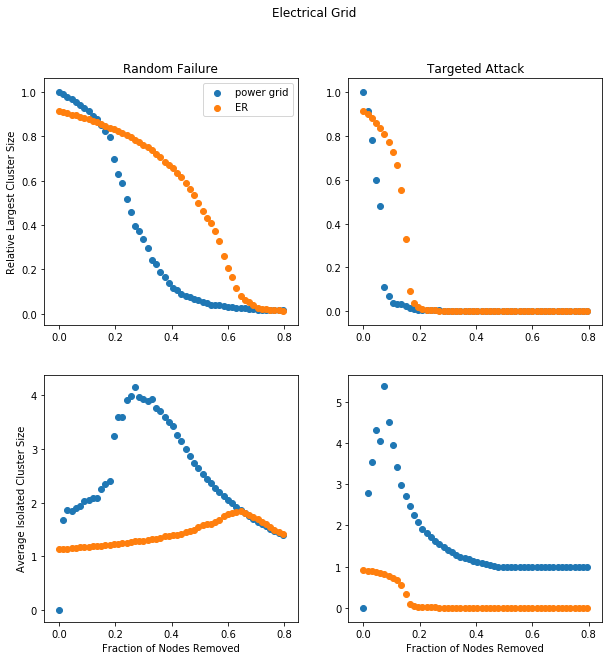

In [32]:
k = 3

plt.figure(figsize=(10,10))
plt.suptitle("Electrical Grid")
plt.subplot(2,2,1)
plt.scatter(eg_rn[0][::k], eg_rn[1][::k])
plt.scatter(er_rn[0][::k], er_rn[1][::k])
plt.title("Random Failure")
plt.ylabel("Relative Largest Cluster Size")
plt.legend(["power grid", "ER"])
plt.subplot(2,2,2)
plt.scatter(eg_tn[0][::k], eg_tn[1][::k])
plt.scatter(er_tn[0][::k], er_tn[1][::k])
plt.title("Targeted Attack")
plt.subplot(2,2,3)
plt.scatter(eg_rn[0][::k], eg_rn[2][::k])
plt.scatter(er_rn[0][::k], er_rn[2][::k])
plt.ylabel("Average Isolated Cluster Size")
plt.xlabel("Fraction of Nodes Removed")
plt.subplot(2,2,4)
plt.scatter(eg_tn[0][::k], eg_tn[2][::k])
plt.scatter(er_tn[0][::k], er_tn[1][::k])
plt.xlabel("Fraction of Nodes Removed")
plt.savefig("C:/Users/wfairman/Desktop/ThinkComplexity2/complex_graph_robustness/reports/figures/fig61.jpg")
plt.show()

## Figure 7
The goal is to comapre random edge removal to the other two types of attacks implemented in the paper

In [33]:
er_rn = er_paper_rn_avg
er_tn = er_paper_tn_avg
er_re = er_paper_re_avg

ws_rn = ws_paper_rn_avg
ws_tn = ws_paper_tn_avg
ws_re = ws_paper_re_avg

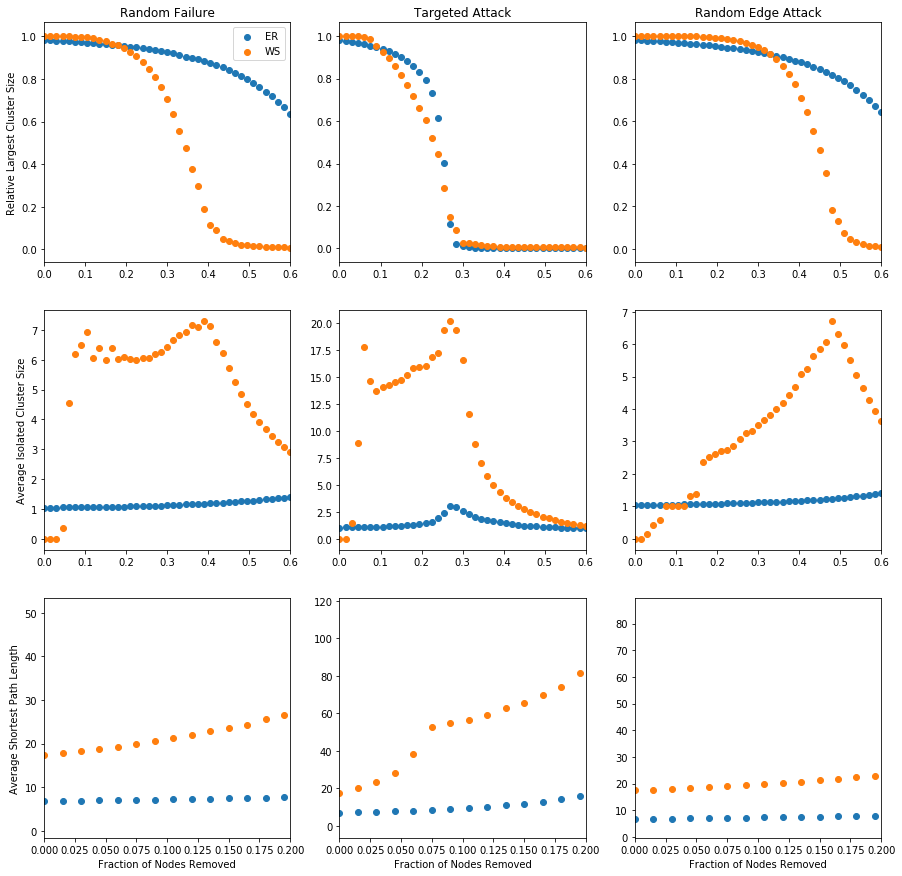

In [34]:
k = 3

plt.figure(figsize=(15,15))
plt.subplot(3,3,1)
plt.scatter(er_rn[0][::k], er_rn[1][::k])
plt.scatter(ws_rn[0][::k], ws_rn[1][::k])
plt.xlim(0, .6)
plt.title("Random Failure")
plt.ylabel("Relative Largest Cluster Size")
plt.legend(["ER", "WS"])
plt.subplot(3,3,2)
plt.scatter(er_tn[0][::k], er_tn[1][::k])
plt.scatter(ws_tn[0][::k], ws_tn[1][::k])
plt.xlim(0, .6)
plt.title("Targeted Attack")

plt.subplot(3,3,3)
plt.scatter(er_re[0][::k], er_re[1][::k])
plt.scatter(ws_re[0][::k], ws_re[1][::k])
plt.xlim(0, .6)
plt.title("Random Edge Attack")



plt.subplot(3,3,4)
plt.scatter(er_rn[0][::k], er_rn[2][::k])
plt.scatter(ws_rn[0][::k], ws_rn[2][::k])
plt.xlim(0, .6)
plt.ylabel("Average Isolated Cluster Size")

plt.subplot(3,3,5)
plt.scatter(er_tn[0][::k], er_tn[2][::k])
plt.scatter(ws_tn[0][::k], ws_tn[2][::k])
plt.xlim(0, .6)

plt.subplot(3,3,6)
plt.scatter(er_re[0][::k], er_re[2][::k])
plt.scatter(ws_re[0][::k], ws_re[2][::k])
plt.xlim(0, .6)



plt.subplot(3,3,7)
plt.scatter(er_rn[0][::k], er_rn[3][::k])
plt.scatter(ws_rn[0][::k], ws_rn[3][::k])
plt.xlim(0, .2)
plt.ylabel("Average Shortest Path Length")
plt.xlabel("Fraction of Nodes Removed")

plt.subplot(3,3,8)
plt.scatter(er_tn[0][::k], er_tn[3][::k])
plt.scatter(ws_tn[0][::k], ws_tn[3][::k])
plt.xlim(0, .2)
plt.xlabel("Fraction of Nodes Removed")

plt.subplot(3,3,9)
plt.scatter(er_re[0][::k], er_re[3][::k])
plt.scatter(ws_re[0][::k], ws_re[3][::k])
plt.xlim(0, .2)
plt.xlabel("Fraction of Nodes Removed")



plt.savefig("C:/Users/wfairman/Desktop/ThinkComplexity2/complex_graph_robustness/reports/figures/fig7.jpg")
plt.show()

## Figure 8
The goal is to compare the edge attack to the other attacks using real-world data

In [43]:
fb_rn = fb_rn_avg
fb_tn = fb_tn_avg
fb_re = fb_re_avg

ws_rn = ws_fb_rn_avg
ws_tn = ws_fb_tn_avg
ws_re = ws_fb_re_avg

eg_rn = eg_rn_avg
eg_tn = eg_tn_avg
eg_re = eg_re_avg

er_rn = er_eg_rn_avg
er_tn = er_eg_tn_avg
er_re = er_eg_re_avg

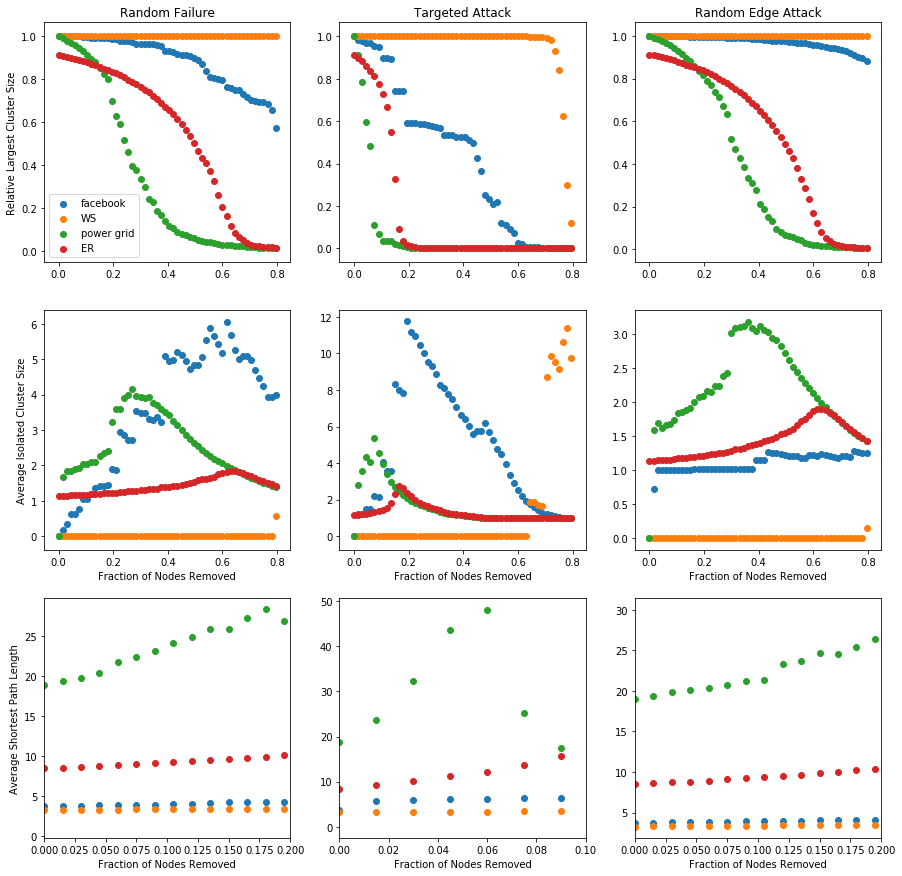

In [48]:
k = 3

plt.figure(figsize=(15,15))
# plt.suptitle("Facebook")

plt.subplot(3,3,1)
plt.scatter(fb_rn[0][::k], fb_rn[1][::k])
plt.scatter(ws_rn[0][::k], ws_rn[1][::k])
plt.scatter(eg_rn[0][::k], eg_rn[1][::k])
plt.scatter(er_rn[0][::k], er_rn[1][::k])
plt.title("Random Failure")
plt.ylabel("Relative Largest Cluster Size")
plt.legend(["facebook", "WS", "power grid", "ER"])

plt.subplot(3,3,2)
plt.scatter(fb_tn[0][::k], fb_tn[1][::k])
plt.scatter(ws_tn[0][::k], ws_tn[1][::k])
plt.scatter(eg_tn[0][::k], eg_tn[1][::k])
plt.scatter(er_tn[0][::k], er_tn[1][::k])
plt.title("Targeted Attack")

plt.subplot(3,3,3)
plt.scatter(fb_re[0][::k], fb_re[1][::k])
plt.scatter(ws_re[0][::k], ws_re[1][::k])
plt.scatter(eg_re[0][::k], eg_re[1][::k])
plt.scatter(er_re[0][::k], er_re[1][::k])
plt.title("Random Edge Attack")

plt.subplot(3,3,4)
plt.scatter(fb_rn[0][::k], fb_rn[2][::k])
plt.scatter(ws_rn[0][::k], ws_rn[2][::k])
plt.scatter(eg_rn[0][::k], eg_rn[2][::k])
plt.scatter(er_rn[0][::k], er_rn[2][::k])
plt.ylabel("Average Isolated Cluster Size")
plt.xlabel("Fraction of Nodes Removed")

plt.subplot(3,3,5)
plt.scatter(fb_tn[0][::k], fb_tn[2][::k])
plt.scatter(ws_tn[0][::k], ws_tn[2][::k])
plt.scatter(eg_tn[0][::k], eg_tn[2][::k])
plt.scatter(er_tn[0][::k], er_tn[2][::k])

plt.xlabel("Fraction of Nodes Removed")

plt.subplot(3,3,6)
plt.scatter(fb_re[0][::k], fb_re[2][::k])
plt.scatter(ws_re[0][::k], ws_re[2][::k])
plt.scatter(eg_re[0][::k], eg_re[2][::k])
plt.scatter(er_re[0][::k], er_re[2][::k])

plt.xlabel("Fraction of Nodes Removed")

plt.subplot(3,3,7)
plt.scatter(fb_rn[0][::k], fb_rn[3][::k])
plt.scatter(ws_rn[0][::k], ws_rn[3][::k])
plt.scatter(eg_rn[0][::k], eg_rn[3][::k])
plt.scatter(er_rn[0][::k], er_rn[3][::k])

plt.xlim(0, .2)
# plt.ylim(3,5)
plt.ylabel("Average Shortest Path Length")
plt.xlabel("Fraction of Nodes Removed")

plt.subplot(3,3,8)
plt.scatter(fb_tn[0][::k], fb_tn[3][::k])
plt.scatter(ws_tn[0][::k], ws_tn[3][::k])
plt.scatter(eg_tn[0][::k], eg_tn[3][::k])
plt.scatter(er_tn[0][::k], er_tn[3][::k])

plt.xlim(0, .1)
# plt.ylim(3,5)
plt.xlabel("Fraction of Nodes Removed")

plt.subplot(3,3,9)
plt.scatter(fb_re[0][::k], fb_re[3][::k])
plt.scatter(ws_re[0][::k], ws_re[3][::k])
plt.scatter(eg_re[0][::k], eg_re[3][::k])
plt.scatter(er_re[0][::k], er_re[3][::k])

plt.xlim(0, .2)
# plt.ylim(3,5)
plt.xlabel("Fraction of Nodes Removed")



plt.savefig("C:/Users/wfairman/Desktop/ThinkComplexity2/complex_graph_robustness/reports/figures/fig8.jpg")
plt.show()

## Figure 8.1
Same as above with Electrical Grid Data

In [37]:
eg_rn = eg_rn_avg
eg_tn = eg_tn_avg
eg_re = eg_re_avg

er_rn = er_eg_rn_avg
er_tn = er_eg_tn_avg
er_re = er_eg_re_avg

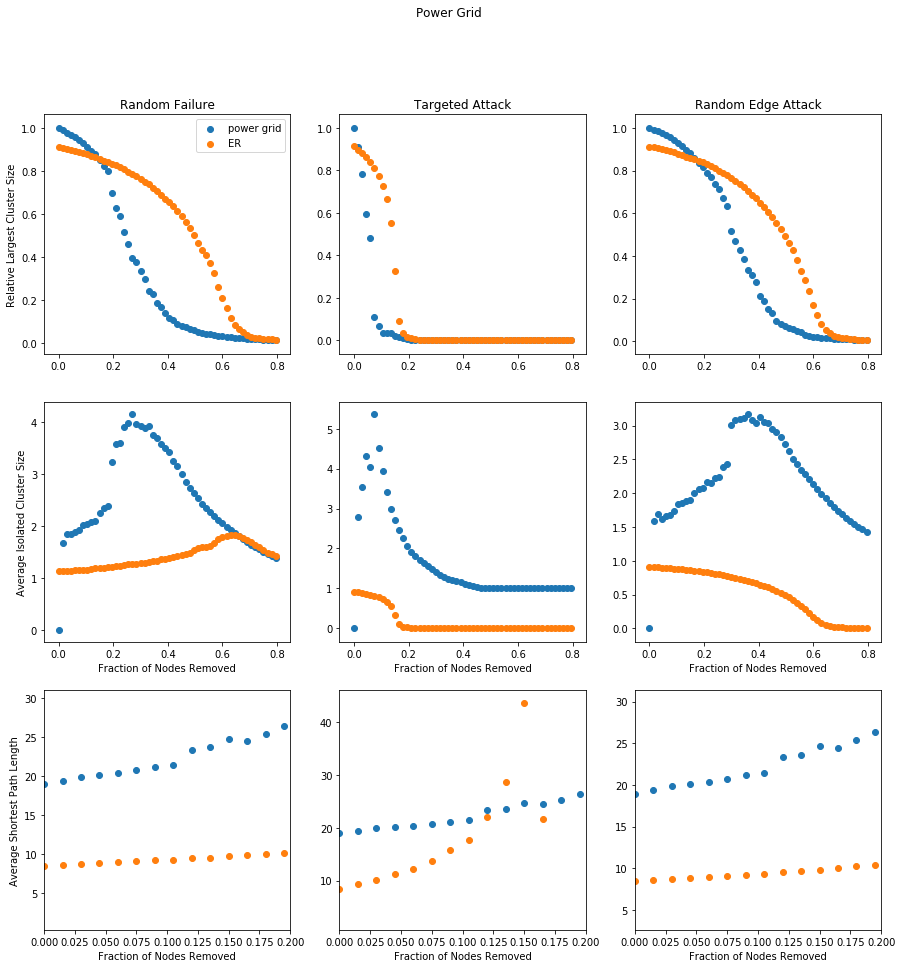

In [38]:
k = 3

plt.figure(figsize=(15,15))
plt.suptitle("Power Grid")

plt.subplot(3,3,1)
plt.scatter(eg_rn[0][::k], eg_rn[1][::k])
plt.scatter(er_rn[0][::k], er_rn[1][::k])
plt.title("Random Failure")
plt.ylabel("Relative Largest Cluster Size")
plt.legend(["power grid", "ER"])

plt.subplot(3,3,2)
plt.scatter(eg_tn[0][::k], eg_tn[1][::k])
plt.scatter(er_tn[0][::k], er_tn[1][::k])
plt.title("Targeted Attack")

plt.subplot(3,3,3)
plt.scatter(eg_re[0][::k], eg_re[1][::k])
plt.scatter(er_re[0][::k], er_re[1][::k])
plt.title("Random Edge Attack")

plt.subplot(3,3,4)
plt.scatter(eg_rn[0][::k], eg_rn[2][::k])
plt.scatter(er_rn[0][::k], er_rn[2][::k])
plt.ylabel("Average Isolated Cluster Size")
plt.xlabel("Fraction of Nodes Removed")

plt.subplot(3,3,5)
plt.scatter(eg_tn[0][::k], eg_tn[2][::k])
plt.scatter(er_tn[0][::k], er_tn[1][::k])
plt.xlabel("Fraction of Nodes Removed")

plt.subplot(3,3,6)
plt.scatter(eg_re[0][::k], eg_re[2][::k])
plt.scatter(er_re[0][::k], er_re[1][::k])
plt.xlabel("Fraction of Nodes Removed")

plt.subplot(3,3,7)
plt.scatter(eg_re[0][::k], eg_re[3][::k])
plt.scatter(er_rn[0][::k], er_rn[3][::k])
plt.xlim(0, .2)
plt.ylabel("Average Shortest Path Length")
plt.xlabel("Fraction of Nodes Removed")

plt.subplot(3,3,8)
plt.scatter(eg_re[0][::k], eg_re[3][::k])
plt.scatter(er_tn[0][::k], er_tn[3][::k])
plt.xlim(0, .2)
plt.xlabel("Fraction of Nodes Removed")

plt.subplot(3,3,9)
plt.scatter(eg_re[0][::k], eg_re[3][::k])
plt.scatter(er_re[0][::k], er_re[3][::k])
plt.xlim(0, .2)
plt.xlabel("Fraction of Nodes Removed")


plt.savefig("C:/Users/wfairman/Desktop/ThinkComplexity2/complex_graph_robustness/reports/figures/fig81.jpg")
plt.show()